In [1]:
######## Atlantic Hurricane Tracker #########

# Pep Cos Espuña
# Barcelona University, Meteorology Master
# Data Analysis and Treatment
# Fall 2019

#############################################

In [1]:
from netCDF4 import Dataset as nc 
from netCDF4 import num2date, date2num 
from datetime import date, timedelta, datetime
import datetime
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import metpy
import metpy.calc as mpcalc
import sys

KeyError: 'PROJ_LIB'

# Objective
#### Atlantic Hurricane Tracker

The main objective of the project is to create a tool that tracks the path, and shows daily evolution of mean sea level pressures and winds, of an atlantic hurricane. The aim of the code is to be as versatile as possible in order to plot any given atlantic hurricane just by introducing any formation and dissipation dates. 

# Data

The data used for the hurricane tracker is: mean sea level pressure and 10m wind speed. This data is obtained from the NCEP North American Regional Reanalysis, which covers the zone where atlantic hurricanes tend to form. Also, it has a resolution of 0.3 degrees, which is fine enough to represent all the intricacies of the hurricane behaviour. The data time resolution used is daily mean, which is good for a general approximation even though a smaller time step would be advantageous as the mean wind speeds would have been more representative. Longitude and Latitude take negative values for West and South, respectively. Also, variables "lat" and "lon" are function of (x,y), which is a cartesian coordinate system with origin at 12.2N;133.5W.

The files are located in the same folder as the current notebook project and they come in yearly formats. For the project's present version there is data for 2005, 2017 and 2019. Each year has three files: 
- Daily Mean Sea Level (ETA model) Pressure (mslet.yyyy.nc)
- Zonal Daily Mean Wind Speed at 10m (uwnd.10m.yyyy.nc)
- Meridional Daily Wind Speed at 10m. (vwnd.10m.yyyy.nc)


The user can find data for different years in the ESRL Physical Sciences Division NCEP NA Reanalysis. The monolevel data has the three files for years ranging from 1979 to 2019. The following link leads to the data used and its basic information: https://www.esrl.noaa.gov/psd/data/gridded/data.narr.monolevel.html

### Hurricane dictionary
The user can add here more atlantic hurricanes. Just the name, formation and dissipation dates need to be filled. If a name is already in use create a distinction between the two. If the event is from a year not listed, download the yearly data as explained above

In [3]:
# 2005, 2017 and 2019 most important hurricanes dictionary. 
# The dictionary stores the day of formation and dissipation.
hurricane_dict = { 
            # ----------------------- 2005 -------------------------------
            "Dennis":[datetime.datetime(year = 2005, month = 7, day = 6), \
                      datetime.datetime(year = 2005, month = 7, day = 12)],\
            "Katrina":[datetime.datetime(year = 2005, month = 8, day = 23), \
                    datetime.datetime(year = 2005, month = 8, day = 30)], \
            "Rita":[datetime.datetime(year = 2005, month = 9, day = 19), \
                     datetime.datetime(year = 2005, month = 9, day = 25)], \
            "Wilma":[datetime.datetime(year = 2005, month = 10, day = 17), \
                      datetime.datetime(year = 2005, month = 10, day = 25)],\
            # ----------------------- 2017 -------------------------------
            "Irma":[datetime.datetime(year = 2017, month = 9, day = 6), \
                     datetime.datetime(year = 2017, month = 9, day = 12)], \
            "Maria":[datetime.datetime(year = 2017, month = 9, day = 21), \
                      datetime.datetime(year = 2017, month = 9, day = 29)],\
            # ----------------------- 2019 -------------------------------
            "Dorian":[datetime.datetime(year = 2019, month = 8, day = 29), \
                      datetime.datetime(year = 2019, month = 9, day = 7)],\
            "Humberto":[datetime.datetime(year = 2019, month = 9, day = 12), \
                      datetime.datetime(year = 2019, month = 9, day = 20)]\
                    }

## Choose the hurricane:
Here the user can choose which atlantic hurricane wants to plot.

In [4]:
# Choose from the following hurricanes in the database:
# 2005 hurricanes: Dennis, Katrina, Rita, Wilma
# 2017 hurricanes: Irma, Maria
# 2019 hurricanes: Dorian, Humberto
hurricane = "Wilma"
# If the user wants to see the results for a different hurricane,
# change to the desired hurricane name, and --> Restart Kernel & Run All

### Data extraction:
To extract the data from the files a function that imports files is defined. A function that extracts the pressure and wind values is also defined. 

Beware: both functions have a lot of "safety nets" to check that the data imported fulfills the structure, shape, spatial and temporal coverage required. This makes both functions very long but, it's for the project's sake.

Code lines intendeded to control possible errors are labelled as "# Error Control: ..."

In [5]:
def import_files (file_name):
    """ Function that opens any netcdf file and saves it to the variable named file
    file_name: Name of the file as it has been saved in the project folder
    return: file
    """
    # Error Control: If the file is not in the folder or the name does not exist, a warning appears.
    try:
        file = nc(file_name, "r") # open netcdf file
    except:
        print("Warning! the file "+file_name+" does not exist. Consider not having it \
        downloaded in the projects folder or having called for a badly referenced hurricane.")
        sys.exit(1)
    return(file)

In [6]:
def extract_p_v (dates, file_mslet, file_uw, file_vw):   
    """ The function is used to extract the mean sea level pressure, 
    the zonal and meridional wind and the magnitude of the wind speed. 
    The function looks long and scary but it's actually just a lot of 
    conditions to check that the files follow the expected structure.
    dates: array with the formation and dissipation dates of the hurricane
    file_mslet: daily mean sea level file for the hurricane's year
    file_uw: daily mean 10m zonal wind speed file for the hurricane's year
    file_vw: daily mean 10m meridional wind speed file for the hurricane's year
    return: mslet, uwnd, vwnd, V, lat, lon
    """
    # read time variable for the given files 
    # Error Control: check if 'time' variable exists
    if "time" in (file_mslet.variables.keys())&(file_uw.variables.keys())&(file_vw.variables.keys()):
        timevar_p = file_mslet.variables["time"]
        timevar_u = file_uw.variables["time"]
        timevar_v = file_vw.variables["time"]
        # Error Control: check if the three timelines coinicde
        if (timevar_p.shape == timevar_u.shape)&(timevar_p.shape == timevar_v.shape):
            timevar = file_mslet.variables["time"]  # assignation of the variable 'time' to 'timevar' array
        else:
            print("Warning! the files have different timelines")
            sys.exit(1)
    else: 
        # Error Control: check which file doesn't have the variable 'time' 
        for i in [file_mslet, file_uw, file_vw]:
            if "time" not in i.variables.keys():
                print("Warning! no variable 'time' in file:\n", str(i))
                sys.exit(1)
                
    # convert the time variable to date format
    dates_file = num2date(timevar[:], units=timevar.units) 
    # day indices for the period between formation adn dissipation of the hurricane
    day_ind = np.array(np.where((dates_file >= dates[0])&(dates_file <= dates[1])))[0]
    
    # Error Control: read latitude if it exists in the files
    if "lat" in (file_mslet.variables.keys())&(file_uw.variables.keys())&(file_vw.variables.keys()):    
        lat_p = file_mslet.variables["lat"][:]
        lat_u = file_uw.variables["lat"][:]
        lat_v = file_vw.variables["lat"][:]
        # Error Control: check if the three files have data from the same latitude coordinates
        if (lat_p.shape == lat_u.shape)&(lat_p.shape == lat_v.shape):
            lat = file_mslet.variables["lat"][:] # assignation of the variable "lat" to 'lat' array
        else:
            print("Warning! the files have different latitude coordinate points")
            sys.exit(1)
    else:
        # Error Control: check which file doesn't have the variable 'lat' 
        for i in [file_mslet, file_uw, file_vw]:
            if "lat" not in i.variables.keys():
                print("Warning! no variable 'lat' in file:\n", str(i))
                sys.exit(1)
    
    # Error Control: read longitude if it exists in the files
    if "lon" in (file_mslet.variables.keys())&(file_uw.variables.keys())&(file_vw.variables.keys()):    
        lon_p = file_mslet.variables["lon"][:]
        lon_u = file_uw.variables["lon"][:]
        lon_v = file_vw.variables["lon"][:]
        # Error Control: check if the three files have data from the same longitude coordinates
        if (lon_p.shape == lon_u.shape)&(lon_p.shape == lon_v.shape):
            lon = file_mslet.variables["lon"][:] # assignation of the variable "lon" to 'lon' array
        else:
            print("Warning! the files have different longitude coordinate points")
            sys.exit(1)
    else:
        # Error Control: check which file doesn't have the variable 'lon' 
        for i in [file_mslet, file_uw, file_vw]:
            if "lon" not in i.variables.keys():
                print("Warning! no variable 'lon' in file:\n", str(i))
                sys.exit(1)
                
    # Error Control: check the existence and the dimension of 'mslet'
    if not("mslet" in file_mslet.variables.keys()):
        print("Warning! no variable 'mslet' in the file")
        sys.exit(1)
    # Error Control: check the dimension of 'mslet' shape
    elif len(file_mslet.variables["mslet"].shape)!=3:
        print("Warning! unexpected varaible 'mslet' with shape different from 3")
        sys.exit(1)
        
    # Error Control: check the existence and the dimension of 'uwnd'
    if not("uwnd" in file_uw.variables.keys()):
        print("Warning! no variable 'uwnd' in the file")
        sys.exit(1)
    # Error Control: check the dimension of 'uwnd' shape
    elif len(file_uw.variables["uwnd"].shape)!=3:
        print("Warning! unexpected varaible 'uwnd' with shape different from 3")
        sys.exit(1)
        
    # Error Control: check the existence and the dimension of 'vwnd'
    if not("vwnd" in file_vw.variables.keys()):
        print("Warning! no variable 'vwnd' in the file")
        sys.exit(1)
    # Error Control: check the dimension of 'vwnd' shape
    elif len(file_vw.variables["vwnd"].shape)!=3:
        print("Warning! unexpected varaible 'vwnd' with shape different from 3")
        sys.exit(1)
    
    # define the M.S.L. pressure, u and v wind for the chosen hurricane period (day_ind) 
    mslet = file_mslet.variables["mslet"][day_ind,:,:]
    uwnd = file_uw.variables["uwnd"][day_ind,:,:]
    vwnd = file_vw.variables["vwnd"][day_ind,:,:]
    # to defnie the velocity magnitude the composition of u and v wind is done.
    V = np.power(np.square(uwnd) + np.square(vwnd), 0.5)

    return(mslet, uwnd, vwnd, V, lat, lon)

### Variable extraction from files:

The previous functions are used here to extract all the data needed

In [7]:
# variable extraction from files

# Extraction of the chosen hurricane dates and duration
if hurricane in hurricane_dict:
    dates = hurricane_dict.get(hurricane)
    duration = dates[1] - dates[0]
# Error Control: Warning in case the hurricane specified is not in the hurricane dictionary
else:
    print("Warning! the hurricane you want to study is not in the dictionary or the name\
            introduced is incorrect.")
    sys.exit(1)

# Data extracted comes in yearly files. Depending on the hurricane chosen,\
# data from a different year will be taken.
file_name_mslet = "mslet."+str(dates[0].year)+".nc"
file_name_uwind = "uwnd.10m."+str(dates[0].year)+".nc"
file_name_vwind = "vwnd.10m."+str(dates[0].year)+".nc"

# open the variable files for mean sea level pressre, zonal and meridional wind speed
file_mslet = import_files(file_name_mslet)
file_uw = import_files(file_name_uwind)
file_vw = import_files(file_name_vwind)

# export the velocity and pressure values.
# mslet: mean sea level daily mean pressures.
# uwnd: zonal mean 10m daily wind speeds.
# vwnd: meridional mean 10m daily wind speeds.
# V: mean daily 10m wind speed magnitude.
# lat, lon: latitude and longitude arrays for every point of the data. 
# (lat & lon are referenced to x & y cartographyc coordinates) 
mslet, uwnd, vwnd, V, lat, lon = extract_p_v(dates, file_mslet, file_uw, file_vw)          


/Users/Pep/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: overflow encountered in square


# Method

A hurricane is mainly defined by its elevated near-surface wind speed. Also it has a very low pressure core, or eye.

The methodolgy to find the atlatinc hurricane location follows these steps:
- Find the maximum wind speed and it's location in the defined box. It is, for the first day of the hurricane's life, a region defined in the atlantic mid-low latitude region.
- Generate a box around the maximum wind speed big enough to include the hurricane center but small enough to avoid interferences from the equatorial low pressures. 
- Find the minimum pressure in the box. That's the location of the hurricane eye.
- Update the box, this time with the hurricane location as the center.
- Go back to the first step for the following day using the updated box.

(after a sensitivity analisys it was seen that a good box is $\pm$5º latitude and longitude)

Two functions are created in these part: "p_min_V_max" finds the hurricane with the method just described and "box_indices" is a function used inside the previous to generate the box to limit the search for Vmax and pmin.

Code lines intendeded to control possible errors are labelled as "# Error Control: ..."

In [8]:
def box_indices (lat, lon, lat_lon_box):
    """ The latitude and longitude box where to find maximum 10m wind speeds
    and minimum mean sea level pressure is updated every day to avoid contamination
    from data to distant from the hurricane path. This function updates de lat and lon box
    indices.
    lat: latitude array with all the latitude positions
    lon: longitude array with all the longitude positions 
    lat_lon_box: updated latitude and longitude box boundaries
    return: lat_box_indices, lon_box_indices
    """
    # Error Control: before creating the index box first needs to be verified that the box 
    # does not exceed the latitude and longitude data boundaries. If the box exceeds the 
    # boundaries it gets reshaped at the, upper or lower, latitutdes or longitudes where it overflows.
    index_outside_bounds = True # While the box is outside the data boundaries it will be = "True"
    # The box gets reshaped with a 'while' until the box falls within boundaries
    while index_outside_bounds == True:
        # check if the South of the box falls within the data boundaries
        if lat_lon_box[0] < np.amin(lat):
            lat_lon_box[0]+=1
            index_outside_bounds = True
        else: index_outside_bounds = False
        # check if the North of the box falls within the data boundaries
        if lat_lon_box[1] > np.amax(lat):
            lat_lon_box[1]-=1
            index_outside_bounds = True
        else: index_outside_bounds = False
        # check if the West of the box falls within the data boundaries
        if lat_lon_box[2] < lon[0,0]:
            lat_lon_box[2]+=1
            index_outside_bounds = True
        else: index_outside_bounds = False
        # check if the East of the box falls within the data boundaries
        if lat_lon_box[3] > lon[-1,-1]:
            lat_lon_box[3]-=1
            index_outside_bounds = True
        else: index_outside_bounds = False
            
    # Find latitude box indices for the given lat_lon_box
    lat_box_indices = np.array(np.where((lat >= lat_lon_box[0])&(lat <= lat_lon_box[1])&(lon >= lat_lon_box[2])
                                        &(lon <= lat_lon_box[3]))[0])
    # Find longitude box indices for the given lat_lon_box
    lon_box_indices = np.array(np.where((lat >= lat_lon_box[0])&(lat <= lat_lon_box[1])&(lon >= lat_lon_box[2])
                                        &(lon <= lat_lon_box[3]))[1])
    return(lat_box_indices, lon_box_indices)

In [9]:
def p_min_V_max (mslet, V, lat, lon):
    """ Function that finds the mean daily location of the chosen hurricane.
    The method is finding the maximum 10m daily mean velocity and the closest 
    minimum pressure near that point where the hurricane eye should be. 
    A latitude/longitude box is used to limit the max_wind and min_p search to make
    it more efficient and avoid taking values of pressure that don't represent the eye
    of the hurricane but a zone with lower pressure than the hurricane (which is not rare)
    mslet: mean sea level daily mean pressures
    V: mean daily 10m wind speed magnitudes
    lat: latitude array with all the latitude positions
    lon: longitude array with all the longitude positions 
    return: lat_lon_hurricane_position, lat_lon_Vmax_position, max_wind_magnitudes
    """
    # initial (day 1) latitude and longitude box 
    # (used to bound the region where the maximum wind speed will be found)
    lat_lon_box = [10, 30, -90, -50]
    
    # definition of the arrays where the hurricane position, 
    # Vmax position and maximum wind speed will be stored
    lat_lon_hurricane_position = []
    lat_lon_Vmax_position = []
    max_wind_magnitudes = []
    
    # day by day hurricane position analisis using a 'for' iteration routine
    for t in range(len(mslet[:,0,0])): 
        # function used to find the indices of the latitude and longitude box
        lat_box_ind, lon_box_ind = box_indices(lat, lon, lat_lon_box)
        # find the maximum wind speed in the box
        max_wind_magnitudes.append(max(V[t,lat_box_ind,lon_box_ind]))
        # find the indexes of the location (position) for the maximum wind speed
        pos_vmax_ind = np.array([lat_box_ind[np.argmax(V[t,lat_box_ind,lon_box_ind])],\
                          lon_box_ind[np.argmax(V[t,lat_box_ind,lon_box_ind])]]).reshape(2)
        # find the lat/lon location for the maximum wind speed
        lat_lon_vmax = np.array([lat[pos_vmax_ind[0],pos_vmax_ind[1]],\
                              lon[pos_vmax_ind[0],pos_vmax_ind[1]]])
        # redefine a lat/lon box around the maximum wind speed location
        lat_lon_box = [lat_lon_vmax[0]-5, lat_lon_vmax[0]+5, lat_lon_vmax[1]-5, lat_lon_vmax[1]+5]
        # function used to find the indices of the latitude and longitude of the redefined box
        lat_box_ind, lon_box_ind = box_indices(lat, lon, lat_lon_box)
        # find the indexes of the location (position) for the minimum pressure near the maximum wind speed
        pos_pmin_ind = np.array([lat_box_ind[np.argmin(mslet[t,lat_box_ind,lon_box_ind])],\
                          lon_box_ind[np.argmin(mslet[t,lat_box_ind,lon_box_ind])]]).reshape(2)
        # find the lat/lon location for the hurricane i.e. minimum pressure near the maximum wind speed
        lat_lon_hurricane = np.array([lat[pos_pmin_ind[0],pos_pmin_ind[1]],\
                              lon[pos_pmin_ind[0],pos_pmin_ind[1]]])
        # redefine a lat/lon box around the hurricane location
        lat_lon_box = [lat_lon_hurricane[0]-5, lat_lon_hurricane[0]+5, lat_lon_hurricane[1]-5, lat_lon_hurricane[1]+5]
        # building the output lat/lon arrays for the hurricane position and maximum velocity position
        lat_lon_hurricane_position.append(lat_lon_hurricane) # day-to-day hurricane position
        lat_lon_Vmax_position.append(lat_lon_vmax) # day-to-day maximum wind speed position
    return(np.array(lat_lon_hurricane_position), np.array(lat_lon_Vmax_position), max_wind_magnitudes)

In [10]:
# Find the daily mean location of the chosen hurricane
# Find the daily mean location of the maximum 10m wind speed
# Find the daily maximum 10m wind speed magnitudes
lat_lon_hurricane_position, lat_lon_Vmax_position, max_wind_magnitudes = p_min_V_max (mslet, V, lat, lon)

# Results

From the data obtained in the previous section, two plots can be generated. The first one is a group of subplots that represent the surface situation (pressure and wind) for each day of the hurricane's duration. The second plot shows the track of the hurricane together with the mean daily maximum speeds found.

### Isobar and Wind speed plotting for every day of the hurricane:

In [11]:
def isobar_wind_plot (lon, lat, mslet, V, u, v, dates, hurricane, duration):
    """Function that plots the mean sea level isobar line contours and the
    10m wind speed magnitude color mesh for each day of the chosen hurricane life.
    lon: longitude array with all the longitude positions 
    lat: latitude array with all the latitude positions
    mslet: mean sea level daily mean pressures
    V: mean daily 10m wind speed magnitudes
    u: zonal mean 10m daily wind speeds
    v: meridional mean 10m daily wind speeds
    dates: array with the formation and dissipation dates of the hurricane
    hurricane: name of the chosen hurricane
    duration: duration of the hurricane
    """
    # create array with the dates of every day during the hurricane's life
    # it will be used to specify the day mean that the subplot represents.
    duration = duration.days+1
    date_ls = [dates[0] + datetime.timedelta(days=x) for x in range(duration)]
    
    # variable used to calculate the subplot rows that the figure must have
    rows = duration // 3 + (duration % 3 > 0)
    
    fig = plt.figure(figsize=(20, rows*8))
    # mslet_plot is the msl pressure converted to hPa
    mslet_plot = mslet/100
    # basemap configuration
    m = Basemap(width=4500000,height=5000000,
                rsphere=(6378137.00,6356752.3142),\
                resolution='l',area_thresh=2500.,projection='lcc',\
                lat_1=30.,lat_2=40,lat_0=32,lon_0=-80.)
    
    # creation of a subplot per day
    for i in range(duration):
        ax = fig.add_subplot(rows,3,i+1)
        # plot title with the date and hurricane name
        ax.set_title(str(date_ls[i].day)+"/"+str(date_ls[i].month)+"/"+str(date_ls[i].year)+", ("+hurricane+")"\
                     , fontsize=20, fontweight='bold')
        x,y = m(lon,lat)
        # wind speed magnitudes plot in a color mesh with values from 5 to 25 m/s
        cs1 = m.pcolormesh(x,y,V[i,:,:], vmin = 5, vmax = 25, cmap=plt.cm.Reds)
        # mean sea level isobar plot with labels 
        cs2 = m.contour(x,y,mslet_plot[i,:,:],12, colors="black")
        plt.clabel(cs2, inline=2, fontsize=12, fmt="%i")
        m.drawcoastlines(linewidth=1.5)
        m.drawparallels(np.arange(-80.,81.,10.))
        m.drawmeridians(np.arange(-180.,181.,10.))
        cbar=m.colorbar(cs1,location='bottom', pad='5%')
        cbar.ax.tick_params(labelsize=15)
        cbar.set_label("Wind speed [m/s]", fontsize=15)

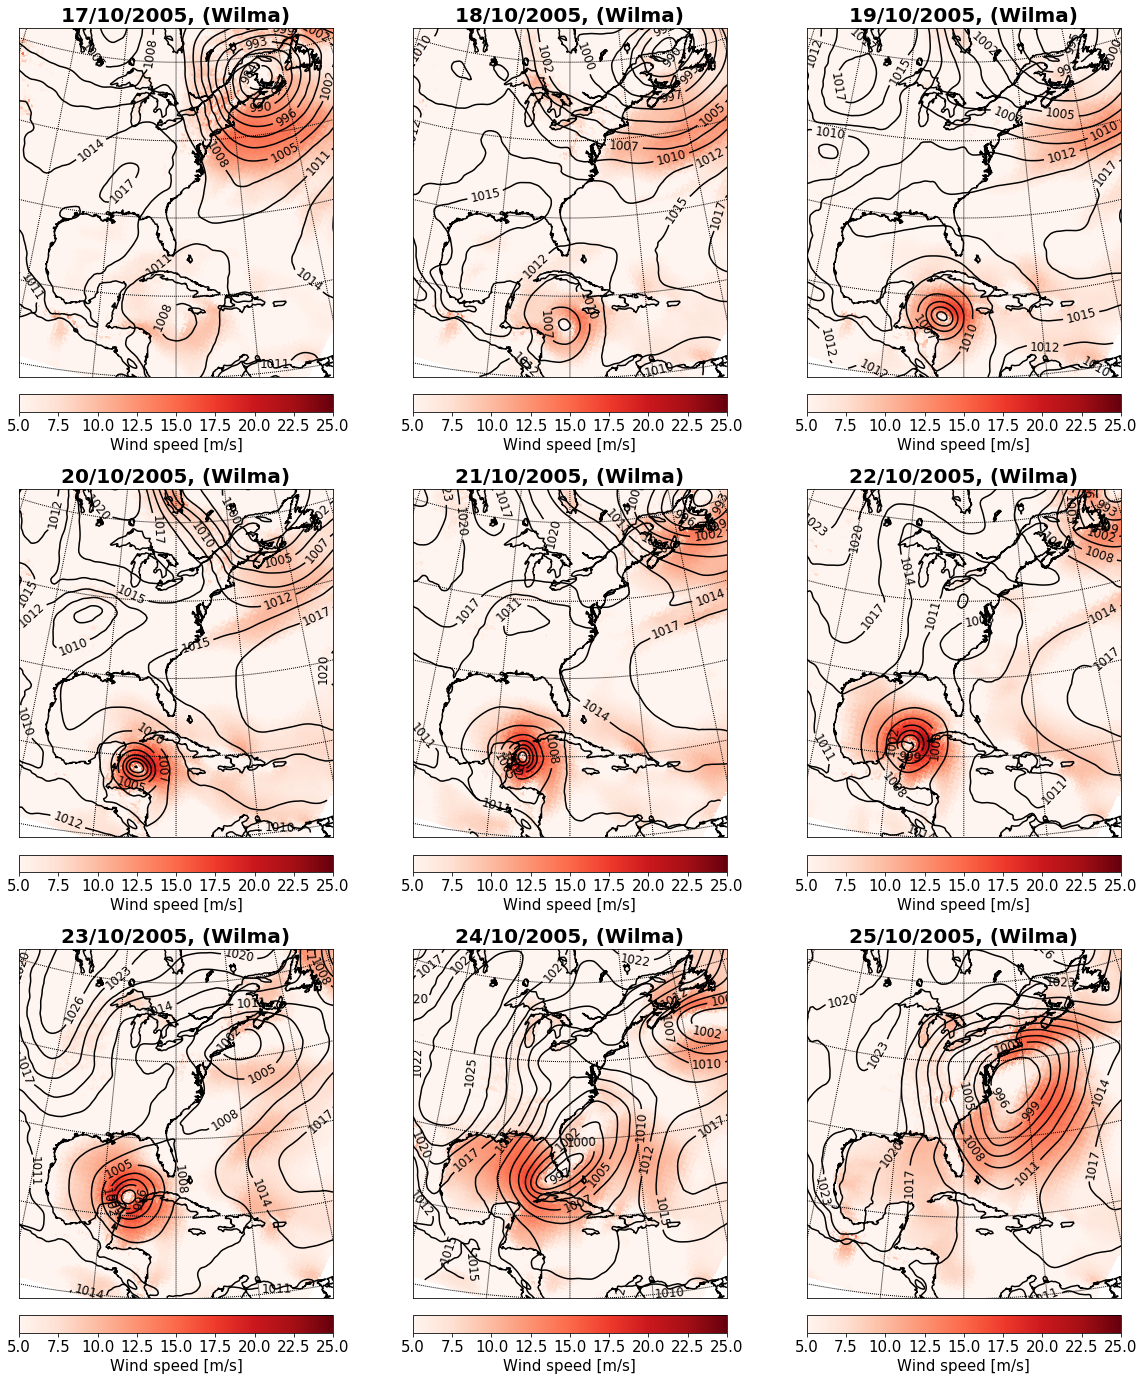

In [12]:
# Isobar and wind plot during the hurricane duration
isobar_wind_plot (lon, lat, mslet, V, uwnd, vwnd, dates, hurricane, duration)

###### Figure 1:    A series of subplots are shown representing each day of the hurricane's duration (from formation to dissipation). The subplots are centered over Florida's East coast and show two main packages of information: daily mean sea level pressure map in hPa (contour lines) and daily mean 10m wind speed magnitudes in m/s (green shadding). The isobars are plotted every 2hPa to make the hurricane formation and disspation more visible. The wind color bar is represented from 5 to 25m/s to show only representative wind speeds and emphasise the hurricane wind speeds as they usually have a daily mean over 10m/s. The titles of the subplots, apart from showing the day represented, show the name that was given to the hurricane.

### Plot the hurricane trajectory:

In [13]:
def path_plotter (lat_lon, lon, lat, hurricane, max_wind_values, dates, duration):
    """ Funtion that plots the path of the chosen hurricane. Each point represents the mean
    position for each day of the hurricane's life. The points are labelled with the day.
    in the upper left corner of the figure the mean maximum 10m wind speed is shown for each day.
    lat_lon: array with daily latitude and longitude positions of the hurricane
    lon: longitude array with all the longitude positions 
    lat: latitude array with all the latitude positions
    hurricane: name of the chosen hurricane
    max_wind_values: array with daily mean maximum 10m wind speed magnitudes
    dates: array with the formation and dissipation dates of the hurricane
    duration: duration of the hurricane
    """
    # create array with the dates of every day during the hurricane's life
    duration = duration.days+1
    date_ls = [dates[0] + datetime.timedelta(days=x) for x in range(duration)]
    
    fig = plt.figure(figsize=(20, 10))
    m = Basemap(width=5500000,height=3700000,
                rsphere=(6378137.00,6356752.3142),\
                resolution='l',area_thresh=300.,projection='lcc',\
                lat_1=30.,lat_2=40,lat_0=25,lon_0=-75.) # figure centered at lat=25 & lon=-75
    # background appearence, parallels and meridians
    m.shadedrelief()
    m.drawparallels(np.arange(-80.,81.,10.))
    m.drawmeridians(np.arange(-180.,181.,10.))
    xx, yy = m(lat_lon[:,1],lat_lon[:,0])
    # plot of the hurricane location for each day
    m.plot(xx, yy, linewidth=3, marker="o", color = 'red', markersize=10)
    # labelling of the points and maximum mean wind speeds
    for j in range(len(date_ls)):
        # date labels for the hurricane locations
        # "xytext" differs between odd and even days in order to avoid collisions between annotations
        plt.annotate(date_ls[j].strftime("%d/%m/%Y"), xytext=(xx[j]+60e4-30e4*(-1)**j, yy[j]),\
                     xycoords='data', fontsize = 11, fontweight='bold', color = 'black', xy=(xx[j],yy[j]),\
                     arrowprops=dict(arrowstyle="-", color = 'black'))
        # maximum wind speeds list for each day. For every day "j" the annotation is lowered 
        # to avoid collisions between annotations
        plt.annotate(date_ls[j].strftime("%d/%m")+" max.avg.wd.spd: "+ \
                     str("{0:.2f}".format(max_wind_values[j]))+" m/s", xy=(0.02, 0.97-j/40),\
                     xycoords='axes fraction', color = 'red', fontsize = 10)
        # annotation in the lower left corner feeaturing the duration of the hurricane
        plt.annotate(hurricane+"'s duration: "+str(duration)+" days", xy=(0.02, 0.02),\
                     xycoords='axes fraction', color = 'red', fontsize = 12)
    # plot title with the hurricane name and year
    plt.title("Hurricane "+hurricane+" track ("+str(dates[0].year)+")", fontsize = 18, fontweight='bold')

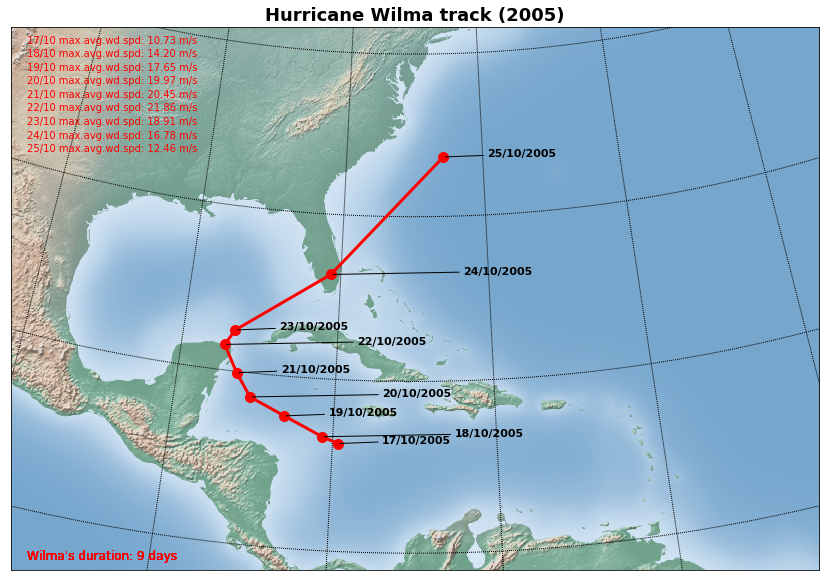

In [14]:
# Plot the hurricane path
path_plotter(lat_lon_hurricane_position, lon, lat, hurricane, max_wind_magnitudes, dates, duration)

###### figure 2: plot centered over Cuba (75ºW) covering between 100º-50ºW and 10º-40ºN. The plot shows the path that the hurricane followed from formation until dissipation. The points (red) represent the mean location of the hurricane during the labelled day (black). The connection between the points is merelly a lineal estimate of the path between two consecutive days, so it must be treated just as an approximation. Aditional daily information can be found in the top left corner of the figure, where the maximum daily 10m mean wind speed is shown (m/s) and it is representative of the hurricane strength during each day (dates are labelled as day/month). In the lower left corner of the figure appears the duration, in days, of the event. The title gives information about the name of the hurricane being represented and the year the event took place.

# Conclusions

The major difficulty of the project was to create an efficient and correct way to find the location of the hurricane eye. Many unefficient and unprecise "p_min_V_max" funtions where developped before obtaining the final one. Also, the appearence of the plots took a long time to get right in order to make the data shown easier to understand. As one of the objectives was to make the hurricane tracker tool as versatile as possible (being able to plot any hurricane the user wants) the plots sometimes have collisions between labels or elements (eg. date labels, wind speed labels, hurricane path...). This is something that could be imporved. 

Despite the difficulties encountered it can be said that the hurricane tracker gives pretty accurate positioning of the low pressure system. Also, its ability to plot any hurricane the user wants fulfills a major objective of the project. Overall, the outcome of the project is positive.

Further work:
- Switch from daily mean data to hourly or 3h or 6h data reanalysis to obtain more detail.
- Apart from the path, show the affected area by heavy winds, heavy rains or flooding.
- Return the hurricane category (Saffir–Simpson scale) for each step of it's life.

enjoy!